## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Хренов |
|---------|--------|
| Группа  | 307    |

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

In [1]:
#!wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
#!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
#!gzip -d mnist.pkl.gz

Теперь загружаем датасет:

In [1]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [2]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

Смотрим на то, какие данные получились:

In [3]:
data.shape

(42000, 784)

Используйте Scikit Learn для разбиения данных на обучающую и тестовую выборку

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [44]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size=20
n_classes=10
dataset = torch.utils.data.TensorDataset(torch.tensor(X_train,dtype=torch.float32),torch.tensor(y_train,dtype=torch.long))
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size)
val_x = torch.tensor(X_train,dtype=torch.float32, device=device)
val_lab = torch.tensor(y_train, device=device)
dataset_tst = torch.utils.data.TensorDataset(torch.tensor(X_test,dtype=torch.float32),torch.tensor(y_test,dtype=torch.long))
dataloader_tst = torch.utils.data.DataLoader(dataset_tst,batch_size=batch_size)
test_x = torch.tensor(X_test,dtype=torch.float32, device=device)
test_lab = torch.tensor(y_test, device=device)

Определяем функцию тренировки и расчета точности

In [75]:
def train(net, dataloader, val_x, val_lab, epochs=10, lr=0.0005):
    optim = torch.optim.Adam(net.parameters(),lr=lr)
    l_dots = []
    ac_dots = []
    for ep in range(epochs):
        for (x,y) in dataloader:               
            z = net(x.to(device))
            loss = torch.nn.functional.cross_entropy(z,y.to(device))
            optim.zero_grad()
            loss.backward()
            optim.step()
        acc = get_acc(net, dataloader, val_x, val_lab)
        l_dots.append(loss)
        ac_dots.append(acc)
        print(f"Epoch {ep}: last batch loss = {loss}, val acc = {acc}")
    plt.plot(l_dots)
    plt.title("loss")
    plt.show()
    plt.plot(ac_dots)
    plt.title("accuracy")
    plt.show()
        
def get_acc(net, dataloader, val_x, val_lab):
    acc = ((torch.max(net(val_x),1)[1]).to(device) == val_lab).float().mean()
    return acc

Строим однослойный персептрон и тренируем его

Epoch 0: last batch loss = 11.130769729614258, val acc = 0.6598791480064392
Epoch 1: last batch loss = 7.43844747543335, val acc = 0.7768656611442566
Epoch 2: last batch loss = 5.1744890213012695, val acc = 0.8216062784194946
Epoch 3: last batch loss = 3.625157594680786, val acc = 0.8447405695915222
Epoch 4: last batch loss = 2.7732133865356445, val acc = 0.858208954334259
Epoch 5: last batch loss = 2.3119802474975586, val acc = 0.8666666746139526
Epoch 6: last batch loss = 2.0858421325683594, val acc = 0.8730987906455994
Epoch 7: last batch loss = 1.9288181066513062, val acc = 0.8779317736625671
Epoch 8: last batch loss = 1.7812988758087158, val acc = 0.8816275596618652
Epoch 9: last batch loss = 1.6033718585968018, val acc = 0.8859630227088928


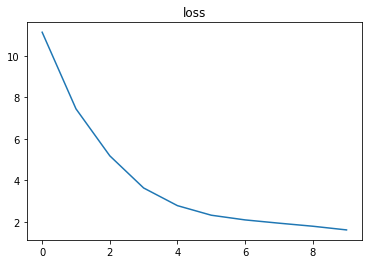

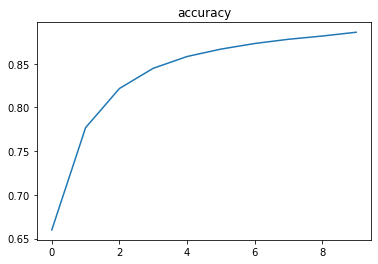

In [94]:
net = torch.nn.Linear(X_train.shape[1],10).to(device)
train(net,dataloader,val_x,val_lab,lr=0.00002)

Матрица ошибок

In [95]:
from sklearn.metrics import confusion_matrix
y_pred = torch.max(net(val_x),1)[1].cpu()
confusion_matrix(y_train, y_pred.numpy())

array([[2688,    0,   14,    9,    3,   25,   21,   10,   22,    7],
       [   0, 3012,   36,   25,    3,    4,    9,   11,   58,    6],
       [  38,   31, 2415,   53,   47,   20,   36,   49,   60,   14],
       [  22,   23,   96, 2449,   10,  108,   14,   34,   86,   38],
       [  11,   12,   17,    5, 2454,    6,   34,   14,   26,  135],
       [  62,   18,   35,   92,   37, 2087,   64,   17,  136,   42],
       [  32,    2,   23,    3,   33,   24, 2591,    4,   24,    4],
       [  10,   13,   37,   11,   28,    6,    2, 2670,   16,  128],
       [  33,   60,   80,   81,   25,  137,   28,   22, 2211,   52],
       [  17,    6,    6,   34,  144,   26,    2,  190,   61, 2354]],
      dtype=int64)

Результат для тестовой выборки

In [97]:
acc = get_acc(net, dataloader_tst, test_x, test_lab)
print(f"accuracy = {acc}")

accuracy = 0.8643578290939331


Опеределим класс для двухслойного персептрона

In [63]:
class MyNet(torch.nn.Module):
    def __init__(self,hidden_size=50,func=torch.nn.Sigmoid()):
        super().__init__()
        self.fc1 = torch.nn.Linear(X_train.shape[1],hidden_size).to(device)
        self.func = func
        self.fc2 = torch.nn.Linear(hidden_size, n_classes).to(device)

    def forward(self,x):
        x = self.fc1(x)
        x = self.func(x)
        x = self.fc2(x)
        return x

Создадим и обучим его

Epoch 0: last batch loss = 0.8471706509590149, val acc = 0.8544420599937439
Epoch 1: last batch loss = 0.5056289434432983, val acc = 0.8887348771095276
Epoch 2: last batch loss = 0.32196393609046936, val acc = 0.9012793302536011
Epoch 3: last batch loss = 0.31423377990722656, val acc = 0.9087775349617004
Epoch 4: last batch loss = 0.21570619940757751, val acc = 0.9170930981636047
Epoch 5: last batch loss = 0.20142094790935516, val acc = 0.9230632781982422
Epoch 6: last batch loss = 0.17355743050575256, val acc = 0.9271144270896912
Epoch 7: last batch loss = 0.22198696434497833, val acc = 0.9317697286605835
Epoch 8: last batch loss = 0.1733541488647461, val acc = 0.933262288570404
Epoch 9: last batch loss = 0.162602961063385, val acc = 0.9363539218902588


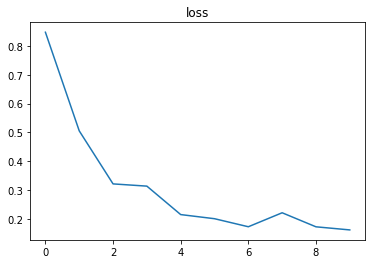

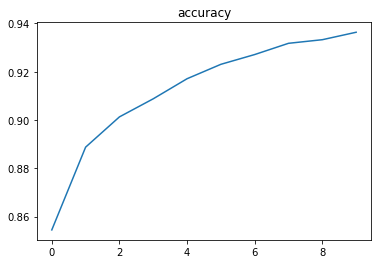

In [92]:
net = MyNet()
train(net,dataloader,val_x,val_lab,lr=0.0001)

Матрица ошибок

In [93]:
y_pred = torch.max(net(val_x),1)[1].cpu()
confusion_matrix(y_train, y_pred.numpy())

array([[2719,    0,   13,    5,    7,   16,   21,    7,   10,    1],
       [   0, 3067,   22,   11,    5,    9,    4,   11,   30,    5],
       [  17,    8, 2567,   25,   34,    8,   22,   35,   38,    9],
       [   7,    4,   64, 2640,    2,   70,   13,   29,   32,   19],
       [   4,    3,   15,    0, 2567,    2,   20,    5,    3,   95],
       [  35,    5,   21,  101,   18, 2303,   30,    9,   45,   23],
       [  20,    3,   11,    1,   10,   35, 2652,    1,    7,    0],
       [   8,   12,   23,    6,   10,    2,    3, 2789,    2,   66],
       [  23,   28,   39,   59,   18,   71,   15,   12, 2417,   47],
       [  14,    4,    2,   36,   70,   13,    1,   53,   19, 2628]],
      dtype=int64)

Результат для тестовой выборки

In [67]:
acc = get_acc(net, dataloader_tst, test_x, test_lab)
print(f"accuracy = {acc}")

accuracy = 0.9203462600708008


Сравним показатели точности для разных передаточных функций

1) sigmoid

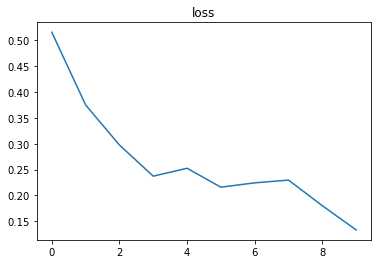

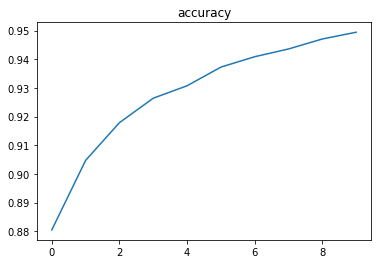

In [71]:
net = torch.nn.Sequential(torch.nn.Linear(X_train.shape[1],100),torch.nn.Sigmoid(),torch.nn.Linear(100, n_classes)).to(device)
train(net,dataloader,val_x,val_lab,lr=0.0001)

2) Softmax

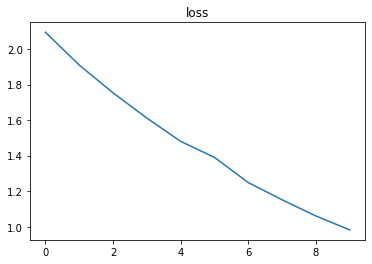

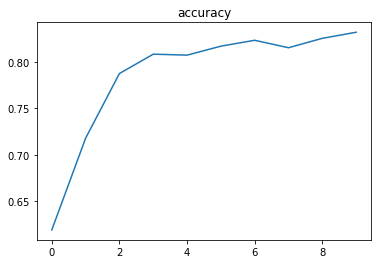

In [73]:
net = torch.nn.Sequential(torch.nn.Linear(X_train.shape[1],100),torch.nn.Softmax(dim=1),torch.nn.Linear(100, n_classes)).to(device)
train(net,dataloader,val_x,val_lab,lr=0.0001)

3) ReLU

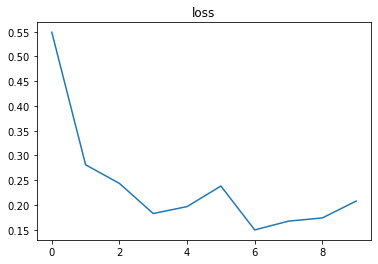

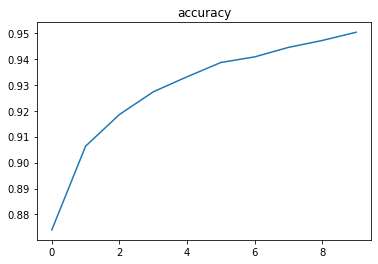

In [74]:
net = torch.nn.Sequential(torch.nn.Linear(X_train.shape[1],100),torch.nn.Sigmoid(),torch.nn.Linear(100, n_classes)).to(device)
train(net,dataloader,val_x,val_lab,lr=0.0001)

Результаты у ReLU и Sigmoid явно лучше чем у Softmax